In [1]:
import os

In [2]:
run = 'local' #local or cloud
os.environ["APP_ENV"] = run

In [3]:
import sys
sys.path.append('..')

In [4]:
from src.grass_functions import*
from src.data.process_inputs import*
%matplotlib inline
#%load_ext autoreload
#%autoreload 2

# Parameters

In [5]:
#set project variables
Project_Area = 'nebraska_regression_stantec'
GRASS_GIS_Projection = projection = '26852' #UTM meters ##set to None if you want to use the DEM's original projection
res = '10m'
## Set variables analysis
data_scale = 'HUC8' #other options HUC12, HUC10, HUC8 OR the field name of the source data to be split <-- case sensitive
select_data = '10270204' #     # Value within the filter_field used for data selection
to_headwaters = False #False if only interested in local huc area
input_shp_name = 'None' #None or must be populated populated with a shapefile polygons if data_scale != HUCXX
buffer = 2000*3.28084 #untis of projection
auto_delete = False

In [15]:
stream_source_nhd = False
stream_shp = 'Turkey_Streams.shp'

In [6]:
huc_level = re.findall("[0-9]+",data_scale)[0]
if huc_level == str(len(select_data)):
    huc_digys = huc_level
else:
    huc_digys = huc_level
    select_data = select_data[:int(huc_digys)]

In [7]:
## Paths:
parent_dir = pl.Path(os.getcwd()).parent/'data'
current_dir = pl.Path(os.getcwd())
outputs_dir =parent_dir/'Rasters'/Project_Area/'Outputs'
vector_dir = parent_dir/'Vectors'/Project_Area
raster_dir = parent_dir/'Rasters'/Project_Area
huc_path = vector_dir/'{}_aoi.geojson'.format(Project_Area)
git_data_repo = current_dir/'data_repository'
if input_shp_name:
    input_shp = git_data_repo/input_shp_name
directory = outputs_dir

### Get area of interest

In [30]:
#read from to vector path from notebook 1
huc_path = vector_dir/'{0}_{1}_aoi.geojson'.format(Project_Area,select_data)
aoi = gpd.read_file(str(huc_path),driver="GeoJSON")

[2023-11-28 17:17:09,321] [WARNING] [geodataframe] : Expecting property name enclosed in double quotes: line 1 column 2 (char 1)


### Start new grass session

In [9]:
#set projection if none exists
if not GRASS_GIS_Projection:
    dem_vrt = raster_dir/'dem'/'dem_{}.vrt'.format(select_data)
    GRASS_GIS_Projection = projection = get_raster_epsg(dem_vrt)
## GRASSGIS Location and Mapsets
Location = Project_Area+'_'+GRASS_GIS_Projection
Mapset = 'PERMANENT'

In [10]:
raster_dir

PosixPath('/home/data/Rasters/nebraska_regression_stantec')

In [11]:
initialize_grass_db(Location, Mapset, GRASS_GIS_Projection)
#initialize_grass_db(Location, Mapset, GRASS_GIS_Projection)

Database Location Exists
Database Mapset Exists
None
{'GISDBASE': '/home/grassdata', 'LOCATION_NAME': 'nebraska_regression_stantec_26852', 'MAPSET': 'PERMANENT'}


Current GRASS GIS 7 environment:


#### Review existing files

In [12]:
#list all grass files
grass_maps = list_existing_grass()

Available vector maps:
HUC81027@PERMANENT
basins@PERMANENT
tmp_bsn@PERMANENT
tmp_bsn_buffer@PERMANENT

Available raster maps:
dem_10270204@PERMANENT


In [13]:
#remove old files if needed
remove_grass_data(grass_maps,'None','raster') #update 'None' with map name or type (i.e. 'raster' or 'vector')

In [36]:
dem = f'dem_{select_data}'
basins = 'aoi'
assert dem+"@PERMANENT" in grass_maps['raster'], 'Check that dem exists in GRASS'

In [37]:
#import stream lines lines
force=True
GRASS_vector_files = [file for line in gs.list_strings(type='vector') for file in [line.split("@")[0]]]
if stream_source_nhd:
    nhd = f'nhd{select_data[:4]}'
    v_stream = f'stream_{select_data}'
    if nhd not in GRASS_vector_files or force:
        gs.run_command('v.import', input=  vector_dir/('NHDPLUS_H_'+select_data[:4]+'_HU4_GDB.gdb'),extent='region', layer = 'NHDFlowline',  output= nhd)

else:
    nhd = f'stream_import'
    v_stream = f'stream_{select_data}'
    if nhd not in GRASS_vector_files or force:
        assert os.path.exists(vector_dir/stream_shp), "stream file is not in vector / project folder"
        assert str(vector_dir/stream_shp)[-4:] != '.gdb', "stream file is gdb but code needs to be updated to accept that filetype"
        gs.run_command('v.import', input=  vector_dir/stream_shp,extent='region',  output= nhd)


#Extract NHD flow lines for upstream HUC12 areas
if v_stream not in GRASS_vector_files or force:
    gs.run_command('v.overlay', ainput = nhd,binput = basins, output = v_stream, operator = 'and')

Check if OGR layer <Turkey_Streams> contains polygons...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
Creating attribute table for layer <Turkey_Streams>...
Importing 222 features (OGR layer <Turkey_Streams>)...
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
-----------------------------------------------------
Building topology for vector map <stream_import@PERMANENT>...
Registering primitives...
Input </home/data/Vectors/nebraska_regression_stantec/Turkey_Streams.shp>
successfully imported without reprojection
Copying vector features from <stream_import@PERMANENT>...
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  

d.vect complete.
d.vect complete.


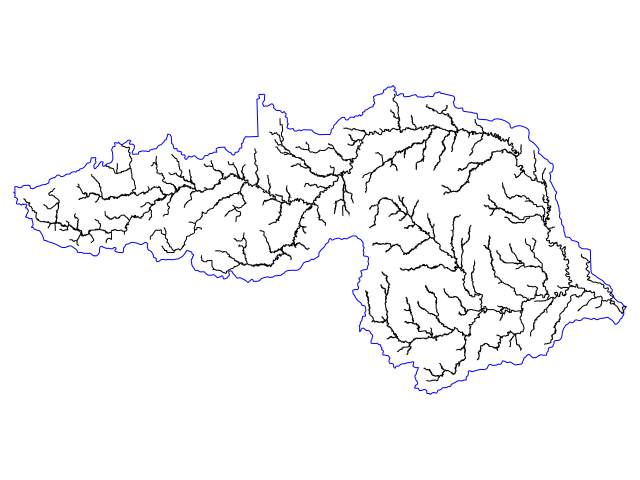

In [44]:
##print watershed flowlines @ Regional scale to confirm data and extent
gs.run_command('d.erase')
gs.run_command('d.vect', map= basins,color='blue',fill_color='none')
gs.run_command('d.vect', map= v_stream,color='black',fill_color='none')
Image(filename="map.png")

In [39]:
def adjust_nhd_lines_no_snap(dem,v_stream,outputs_dir,overwrite = False):
    print("combining watershed lines and nhd lines")
    gs.run_command("v.build.polylines",input=v_stream,output= '{}_poly'.format(v_stream),cats='same')
    gs.run_command("v.to.points", input= '{}_poly'.format(v_stream), type='line', output='{}_pts'.format(v_stream),dmax=5)
    gs.run_command('v.drape',input='{}_pts'.format(v_stream),elevation=dem,type='point',output='{}_pts_3d'.format(v_stream))

In [40]:
adjust_nhd_lines_no_snap(dem,v_stream,outputs_dir,overwrite = True)

combining watershed lines and nhd lines


Building topology for vector map <stream_10270204_poly@PERMANENT>...
Registering primitives...
   2   5   8  11  14  17  20  23  26  29  32  35  38  41  44  47  50  53  56  59  62  65  68  71  74  77  80  83  86  89  92  95  98 100
Building topology for vector map <stream_10270204_pts@PERMANENT>...
Registering primitives...
v.to.points complete. 856515 points written to output vector map.    900    1000    1100    1200    1300    1400    1500    1600    1700    1800    1900    2000    2100    2200    2300    2400    2500    2600    2700    2800    2900    3000    3100    3200    3300    3400    3500    3600    3700    3800    3900    4000    4100    4200    4300    4400    4500    4600    4700    4800    4900    5000    5100    5200    5300    5400    5500    5600    5700    5800    5900    6000    6100    6200    6300    6400    6500    6600    6700    6800    6900    7000    7100    7200    7300    7400    7500    7600    7700    7800    7900    8000    8100    8200    8300    8400  

In [53]:
def get_increases_along_streams(point_list,cat,outputs_dir,sr,ratio):
        
    #attribute geometry for analysis
    index = 1
    df_pts = pd.DataFrame(columns = ['x','y','z'])
    df_lines_out = gpd.GeoDataFrame()
    for point in point_list:
        coord = point.coords[0]
        df_pts = df_pts.append(pd.DataFrame([[coord[0],coord[1],coord[2]]],columns = ['x','y','z']))
    df_pts.reset_index(inplace=True)
    df_pts.loc[:,'delta'] = df_pts.loc[:,'z'].diff()
    df_pts.loc[:,'x_distance'] = df_pts.loc[:,'x'].diff()
    df_pts.loc[:,'y_distance'] = df_pts.loc[:,'y'].diff()
    df_pts.loc[:,'x_distance'].fillna(0.0,inplace=True)
    df_pts.loc[:,'y_distance'].fillna(0.0,inplace=True)
    df_pts['distance'] = np.sqrt(df_pts['y_distance'].apply(lambda x: x**2) + df_pts['x_distance'].apply(lambda x: x**2))
    df_pts['delta'].fillna(0.0,inplace=True)
    df_pts_out = pd.DataFrame(columns = df_pts.columns.to_list())
    increases = df_pts.loc[df_pts['delta'] > 0].index.to_list()
    seg = 1
    while increases:
        rolling_sum = df_pts.loc[increases[0]]['delta']
        i = 1
        while rolling_sum >= 0:
            rolling_sum += df_pts.loc[increases[0]+i:increases[0]+i+1]['delta'].sum()
            if rolling_sum >= 0 and increases[0]+i+1 <= df_pts.last_valid_index():
                i+= 1
                pass
            else:
                df_seg = df_pts.loc[increases[0]-1:increases[0]+i]
                road_pts, slope = roads_detector(df_seg,ratio)
                if road_pts.empty is False:
                    road_pts = gpd.GeoDataFrame(road_pts, geometry=road_pts.apply(lambda r: shapely.geometry.Point(r.x,r.y,r.z), axis=1))
                    road_pts['segment'] = seg
                    seg+=1
                    # generate Linestrings grouping by station
                    gls = gpd.GeoDataFrame(geometry=gpd.GeoSeries(road_pts.groupby('segment').apply(lambda d: shapely.geometry.LineString(d["geometry"].values))))
                    gls['ratio'] = slope
                    gls.set_crs(crs = sr, inplace=True,allow_override=True)
                    df_lines_out = df_lines_out.append(gls)
                    
                remove_list = []
                for k in range(i):
                    if increases[0]+k in increases:
                        remove_list.append(increases[0]+k)
                        if increases[0]+k == df_pts.last_valid_index():
                            if increases[0]+k not in remove_list:
                                remove_list.append(increases[0]+k)
                for removal in remove_list:
                    increases.remove(removal)
                if not increases:
                    rolling_sum = -0.1 
    #add road names
    if df_lines_out.empty is False:
        nad83 = 4269
        df_lines_out = df_lines_out.to_crs(nad83)
        #df_lines_out['esri_geo'] = df_lines_out['geometry'].apply(lambda x : get_esri_JSON(x.__geo_interface__,nad83))
        #df_lines_out['crossing'] = df_lines_out['esri_geo'].apply(lambda x : get_road_names(x,nad83,'NAME'))
        #df_lines_out = df_lines_out[['crossing','geometry']]
        df_lines_out = df_lines_out[['geometry']]
        df_lines_out = df_lines_out.to_crs(sr)
    #export
    if df_lines_out.empty is False:
        df_lines_out.set_crs(crs = sr, inplace=True,allow_override=True)
        df_lines_out.to_file(str(outputs_dir/'hydro_connectors_in_{}.geojson'.format(cat)),driver='GeoJSON')

In [54]:
def create_hydro_connectors(dem,v_stream,outputs_dir, projection, ratio = 15, overwrite = False):
    hydro_connectors = dem[:dem.find('dem')]+'hydro_connectors'
    GRASS_vector_files= [file for line in gs.list_strings(type='vector') for file in [line.split("@")[0]]]
    if  hydro_connectors in GRASS_vector_files and overwrite is False:
        logger.info("hydroconnectors exist. Not recreating.")
    else:
        #clean up existing files
        if os.path.exists(outputs_dir) and os.path.isdir(outputs_dir):
            shutil.rmtree(outputs_dir)
        os.makedirs(outputs_dir)
        gs.run_command('g.remove', type ='vector', name=hydro_connectors, flags ='f')

        logger.info("exporting nhd lines for road and dam analysis")

        cats = list(gs.parse_command('v.db.select',map='{}_pts_3d'.format(v_stream),columns='cat',flags='c',separator=',').keys())
        for cat in cats:
            gs.run_command('v.out.ascii',flags='c',type='point',input ='{}_pts_3d'.format(v_stream), cats= cat, output=outputs_dir/'nhd_out_{}.txt'.format(cat),format='wkt')
            
            points = []
            df_points = pd.DataFrame()
            with open(outputs_dir/"nhd_out_{}.txt".format(cat), 'r') as fd:
                txt = fd.read()
            points = txt.splitlines()
            df_points = gpd.GeoDataFrame(geometry=gpd.GeoSeries.from_wkt(points, index=None, crs=int(projection)))    
            temp = get_increases_along_streams(df_points.geometry.to_list(),cat,outputs_dir,int(projection),ratio=ratio)

In [55]:
def get_road_names(esri_geo,sr,out_field):
    #set base URL information for road name check
    api_base = 'https://tigerweb.geo.census.gov/arcgis/rest/services/TIGERweb/Transportation/MapServer'
    params = {'f':'json'}
    # layer_index = layer_indexer_all(api_base,params)
    layer_index = [8]
    query_params = {'geometry': esri_geo, 'geometryType': 'esriGeometryPolyline','f':'json','outFields':out_field,'inSR':sr,'returnGeometry':'false','distance':'25'}
    for layer in layer_index:
        query_url = '{0}/{1}/query'.format(api_base,layer)
        response = esri_rest_query(query_url,query_params)
        if 'features' in response.keys():
            if response['features']:
                print(response['features'][0]['attributes']['NAME'])
                return response['features'][0]['attributes']['NAME']
            else:
                pass
        else:
            pass
    return 'None'

In [56]:
def esri_rest_query(service:str,parameters:dict) -> list:
    '''
    takes a url and parameters to 
    query arcGIS REST service for information
    SSL bypassed because of 1 case of verification
    error. This will be updated if an alternative source can be located
    '''
    gcontext = ssl.SSLContext()  # Needed to bypass SSL verification issue
    data = urllib.parse.urlencode(parameters)
    data = data.encode('ascii') # data should be bytes
    req = urllib.request.Request(service, data)
    with urllib.request.urlopen(req,context=gcontext) as response:
        projects = json.loads(response.read())
    return projects

In [57]:
#update needs. need to do accum process to roadway
create_hydro_connectors(dem,v_stream,outputs_dir, projection, ratio = 10, overwrite = False) #higher ratio will capture more cases. set roads only = False if you want all embankments along NHS

[2023-11-17 21:57:52,479] [INFO] [853419517] : exporting nhd lines for road and dam analysis
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetching data...
Fetchi

In [ ]:
def topo_carve(dem,overwrite = False):
    hydro_connectors = dem[:dem.find('dem')]+'hydro_connectors'
    reg = gs.parse_command('g.region', raster=dem, flags='pgm', zoom=dem,align=dem)
    cell_size = float(reg.nsres)
    GRASS_raster_files= [file for line in gs.list_strings(type='raster') for file in [line.split("@")[0]]]
    if "{}_hydro_enforced".format(dem) in GRASS_raster_files and overwrite is False:
        logger.info('hydro enforced dem already exists. Not recarving')
    else:
        logger.info('burning hydro_connectors into DEM')
        gs.run_command(
            'r.carve', 
            output="{}_hydro_enforced".format(dem),
            raster=dem, vector=hydro_connectors, 
            width = cell_size*2,
            depth="0.0", overwrite=True, flags="n"
        )  
    return output

In [ ]:
carved_dem = topo_carve(dem)

## End

In [266]:
#consolidate by HUC and export as shp
temp_files = []
for file in os.listdir(outputs_dir):
    if file.endswith(".geojson"):
        temp_files.append(file)
    
compiled_lines = gpd.GeoDataFrame(pd.concat([gpd.read_file(outputs_dir/gj) for gj in temp_files],ignore_index=True))
#compiled_lines.set_crs(crs = projection, inplace=True,allow_override=True)
compiled_lines.to_file(outputs_dir/'hydro_connectors_in_{}.shp'.format(select_data)) 

In [267]:
for tfile in temp_files:
    os.unlink(outputs_dir/tfile)

## Imports

### Get HUC number

### Start new grass session

### Create Curvature Lines along streams in Grass GIS (for hydro-enforcing)

In [9]:
config = create_draft_stream_accum(config,overwrite = True)

[2022-03-21 17:46:51,178] [INFO] [grass_functions] : performing initial pass of watershed analysis
SECTION 1a (of 5): Initiating Memory.
SECTION 1b (of 5): Determining Offmap Flow.
   0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
SECTION 2: A* Search.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  98 100
SECTION 3: Accumulating Surface Flow with SFD.
   1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71  73  75  77  79  81  83  85  87  89  91  93  95  97  99 100
SECTION 4: Watershed determination.
   0   2   4   6   8  10  12  14  16  18  20  22  24  26  28  30  32  34  36  38  40  42  44  46  48  50  52  54  56  58  60  62  64  66  68  70  72  74  76  78  80  82  84  86  88  90  92  94  96  9

### Create Accumulation, Flow Direction and Flow lines

In [ ]:
config = develop_watershed_data(config, overwrite = True)

### Create 1sq mile threshold

In [27]:
def delineate_at_threshold(config,overwrite = False):
    accum = config.accum
    threshold = config.thresholds['stream']
    reg = gs.parse_command('g.region', raster=accum, flags='pgm',align=accum)
    cell_area = (float(reg.nsres)*float(reg.ewres))
    target_accum_cells = threshold / cell_area
    gs.run_command('r.mapcalc',overwrite=True,\
                      expression='above_thresh = if({0} < {1},null(),{0})'.format(accum, target_accum_cells))
    gs.run_command('r.mapcalc',overwrite=True,\
                      expression='outlet = if({0} = nmin({0}),1,null())'.format(accum))
    gs.run_command('r.to.vect',overwrite=True,\
                          input = 'outlet', output = 'outlet_vec',\
                          type='point')
    v_basin = delineate_at_point('outlet',config.drain,'thresholds')
    gs.run_command('v.out.ogr', input=  v_basin ,type = 'area',output = out_dir/'{}.gpkg'.format(v_basin), format = 'GPKG')
    
def delineate_at_point(point_v,flow_dir,basin_name):
    gs.run_command('r.stream.basins',overwrite=True,\
              direction=flow_dir,points=point_v,\
              basins = 'r_{}'.format(basin_name))
    gs.run_command('r.to.vect',input = 'r_{}'.format(basin_name),output = 'v_{}'.format(basin_name), type = 'area')
    gs.run_command('v.clean',input = 'v_{}'.format(basin_name),threshold = 5000,tool='rmarea',output = '{}_clean'.format(v_basins))
    return 'v_{}'.format(basin_name)
    

In [28]:
delineate_at_threshold(config,overwrite = True)

Extracting points...
   0   3   6   9  12  15  18  21  24  27

KeyboardInterrupt: 